In [2]:
from openmmtools.multistate import MultiStateSamplerAnalyzer, MultiStateReporter
from openmmtools.openmm_torch.repex import get_atoms_from_resname
from openmm import app
import numpy as np
import os
import argparse
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns
from MDAnalysis.lib.distances import calc_dihedrals
import MDAnalysis as mda
import mdtraj
import logging
# import nglview as nv
import numpy as np
from typing import Optional

logger = logging.getLogger(__name__)

In [3]:
# Analysis functions from https://github.com/fjclark/ani_mmml_corrections


def get_correction(ana_com, ana_sol, temp):
    """Get correction from complex and solvent repex.nc files.

    Args:
        ana_com (str): Analyser for complex leg.
        ana_sol (str): Analyser for solvent leg.
        temp (int): Temperature in K.

    Returns:
        dict: Dictionary of correction, complex, and solvent free energies.
    """
    corr_dict = {}
    R = 0.00198720425864083  # Gas constant in kcal/mol/K

    # Complex
    corr_dict["complex"] = {}
    fr_nrg_com = ana_com.get_free_energy()
    corr_dict["complex"]["dg"] = fr_nrg_com[0][0][-1] * R * temp
    corr_dict["complex"]["er"] = fr_nrg_com[1][0][-1] * R * temp
    

    # Solvent
    corr_dict["solvent"] = {}
    fr_nrg_sol = ana_sol.get_free_energy()
    corr_dict["solvent"]["dg"] = fr_nrg_sol[0][0][-1] * R * temp
    corr_dict["solvent"]["er"] = fr_nrg_sol[1][0][-1] * R * temp

    # Overall
    dg = corr_dict["complex"]["dg"] - corr_dict["solvent"]["dg"]
    err = np.sqrt(corr_dict["solvent"]["er"]**2 +
                  corr_dict["complex"]["er"]**2)
    corr_dict["corr"] = {"dg": dg, "er": err}
   

    return corr_dict

def write_correction(ana_com, ana_sol, temp, out_file):
    """Write correction to file.

    Args:
        ana_com (str): Analyser for complex leg.
        ana_sol (str): Analyser for solvent leg.
        temp (int): Temperature in K.
        out_file (str): Path to output file.
    """
    corr_dict = get_correction(ana_com, ana_sol, temp)
    with open(out_file, "w") as f:
        f.write(
            f"Correction: {corr_dict['corr']['dg']:.3f} +/- {corr_dict['corr']['er']:.3f} kcal/mol\n")
        f.write(
            f"Complex: {corr_dict['complex']['dg']:.3f} +/- {corr_dict['complex']['er']:.3f} kcal/mol\n")
        f.write(
            f"Solvent: {corr_dict['solvent']['dg']:.3f} +/- {corr_dict['solvent']['er']:.3f} kcal/mol\n")


def plot_correction_timeseries(output_com, output_sol, temp, out_file, components=None, 
    step_size=10, n_iterations_com=5000, n_iterations_sol=5000):
    """Plot correction timeseries.

    Args:
        output_com (str): Path to complex leg output.
        output_sol (str): Path to solvent leg output.
        temp (int): Temperature in K.
        out_file (str): Path to output file.
        components (list, optional): Components to plot. Subset of "corr", "complex", and "solvent".
        Defaults to None, in which case all components are plotted.
        step_size (int, optional): Step size (in iterations) between free energy evaluations. Defaults to 100.
        n_iterations_com (int, optional): The number of iterations simulated for the complex leg. Defaults to 5000.
        n_iterations_sol (int, optional): The number of iterations simulated for the solvent leg. Defaults to 5000.
    """
    
    cumulative_corrs = {}
    n_iterations = {"complex": n_iterations_com, "solvent": n_iterations_sol, "corr": max(n_iterations_com, n_iterations_sol)}

    # Get corrections for each value of max_n_iterations
    for i, max_n_iterations in enumerate(range(step_size, n_iterations["corr"] + step_size, step_size)):
        rep_com = MultiStateReporter(output_com)
        ana_com = MultiStateSamplerAnalyzer(
            rep_com, max_n_iterations=min(max_n_iterations, n_iterations["complex"]))
        rep_sol = MultiStateReporter(output_sol)
        ana_sol = MultiStateSamplerAnalyzer(
            rep_sol, max_n_iterations=min(max_n_iterations, n_iterations["solvent"]))
        corr_dict = get_correction(ana_com, ana_sol, temp)
        
        # Initialise the dictionary
        if i == 0:
            for energy_type in corr_dict:
                cumulative_corrs[energy_type] = {}
                for k in corr_dict[energy_type]:
                    cumulative_corrs[energy_type][k] = []
        # Populate the dictionary
        for energy_type in corr_dict:
            for k in corr_dict[energy_type]:
                cumulative_corrs[energy_type][k].append(
                    corr_dict[energy_type][k])

    # Offset energies to be close to zero (and therefore the correction)
    offset = np.mean(cumulative_corrs["complex"]["dg"])
    cumulative_corrs["complex"]["dg"] = np.array(cumulative_corrs["complex"]["dg"]) - offset
    cumulative_corrs["solvent"]["dg"] = np.array(cumulative_corrs["solvent"]["dg"]) - offset

    # Find components to plot
    if components is None:
        components = ["corr", "complex", "solvent"]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    for energy_type in components:
        # Truncate the results from cumulative_corrs at the max number of frames stored,
        # because the shorter simulation is made artificially longer by duplicating the final 
        # result in order to allow the correction to be calculated up to the number of iterations
        # for the longer simulation
        iterations_data_points = list(range(step_size, n_iterations[energy_type] + step_size, step_size))
        n_data_points = len(iterations_data_points) 
        ax.plot(iterations_data_points, cumulative_corrs[energy_type]["dg"][:n_data_points], label=energy_type)
        # Find range to fill between
        upper = np.array(cumulative_corrs[energy_type]["dg"]) + \
            np.array(cumulative_corrs[energy_type]["er"])
        lower = np.array(cumulative_corrs[energy_type]["dg"]) - \
            np.array(cumulative_corrs[energy_type]["er"])
        ax.fill_between(range(step_size, n_iterations[energy_type] +
                        step_size, step_size), upper[:n_data_points], lower[:n_data_points], alpha=0.3)

    # set labels and fontsize
    ax.set_xlabel("Iteration", fontsize=22)
    ax.set_ylabel("Free energy / kcal.mol$^{-1}$", fontsize=22)
    ax.legend()
    fig.savefig(out_file, dpi=1000)


##################################
# Analysis of single leg
##################################

# TODO: Plot PMF?

# Get picture of ligand

def get_lig_idx(name, file):
    """Get ligand index from sdf file

    Args:
        name (str): Ligand name.
        file (str): Path to sdf file.

    Returns:
        int: Index of ligand in sdf file.
    """
    ligs = []
    with open(file) as f:
        for l in f:
            if l.startswith("lig"):
                ligs.append(l[4:-1])  # Remove lig and \n

    return ligs.index(name)


def get_mol_image(sdf_file, idx):
    """Get image of molecule from sdf file.

    Args:
        sdf_file (str): Path to sdf file.
        idx (int): Index of molecule in sdf file.

    Returns:
        PIL.Image: Image of molecule.
    """
    sdfs = Chem.SDMolSupplier(sdf_file)
    mol = Chem.MolToSmiles(sdfs[idx])
    mol = Chem.MolFromSmiles(mol)
    im = Draw.MolToImage(mol)
    return im

# Write statistical Inefficiency


def write_stats(analyser, outfile):
    """Write out statics.

    Args:
        analyser (openmmtools.multistate.MultiStateSamplerAnalyzer): Analyser for leg.
        outfile (str): Path to output file.
    """
    with open(outfile, "wt") as f:
        f.write(f"n_states: {analyser.n_states}\n")
        f.write(f"n_iterations: {analyser.n_iterations}\n")
        f.write(
            f"n_equilibrated_iterations: {analyser.n_iterations - analyser.n_equilibration_iterations}\n")
        f.write(
            f"n_decorrelated_iterations: {len(analyser._decorrelated_iterations)}\n")
        f.write(
            f"statistical inefficiency: {analyser.statistical_inefficiency}\n")


# Overlap

def plot_overlap(lig, leg, analyser, out_file):
    """Plot overlap matrix for ligand for given leg,
    and write out the off-diagonal overlap to a txt
    file.

    Args:
        lig (str): Name of the ligand
        leg (str): Complex or solvent. Name of the leg.
        analyser (openmmtools.multistate.MultiStateSamplerAnalyzer): Analyser for leg.
        out_file (str): Path to output files, including name of the .png and .txt files
        to write.
    """

    overlap_dict = analyser.mbar.computeOverlap()
    #overlap = np.array(overlap_dict["matrix"])[::2,::2]
    overlap = np.array(overlap_dict["matrix"])
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.heatmap(overlap, ax=ax, square=True, linewidths=.5)
    ax.set_title(f"{lig} {leg} overlap")
    fig.savefig(f"{out_file}.png", bbox_inches="tight")

    # Write out off-diagonal overlap to file
    with open(f"{out_file}.txt", "w") as f:
        f.write("############################################################\n")
        f.write(f"Overlap for {lig} {leg}\n")
        for i in range(1, overlap.shape[0]):
            f.write(
                f"Off-diagonal overlap between windows {i-1} and {i} = {overlap[i-1,i]:.3f}\n")

# Replica mixing plot
            
##################################################################################
# Acknowlegdement: This function has been modified from YANK
#  https://github.com/choderalab/yank/blob/master/Yank/reports/notebook.py
##################################################################################

def plot_replica_mixing(analyser, out_file: Optional[str] = None, n_frames = None):
        """
        Generate the replica trajectory mixing plots. Show the state of each replica as a function of simulation time
        Args:
            analyser (openmmtools.multistate.MultiStateSamplerAnalyzer): Analyser for leg.
            out_file (str): Name to save plot to.
            to write.
        """
        # Read the data
        sampled_energies, _, _, state_kn = analyser.read_energies()
        n_replicas, n_states, n_iterations = sampled_energies.shape

        # Create plot
        fig, axs = plt.subplots(nrows=n_states, ncols=1, figsize=(10, n_states+2))

        # Loop through all states
        for replica_index in range(n_replicas):
            # Get axis
            ax = axs[replica_index]
            # Actually plot
            if n_frames is not None:
                ax.plot(state_kn[replica_index, :n_frames], 'k.')
                ax.set_xlim([0, n_frames]) 
            else:
                ax.plot(state_kn[replica_index, :], 'k.')
                ax.set_xlim([0, n_iterations]) 
            # Format plot
            

            ax.set_ylim([0, n_states])
            ax.set_ylabel("State index")
            ax.set_title(f"Replica {replica_index}")
            if replica_index < n_replicas - 1:
                ax.set_xticks([])
            else:
                ax.set_xlabel("Iteration number")

        # Format plot
        fig.set_tight_layout(True)
        if out_file is not None:
            fig.savefig(out_file, dpi=1000)


# RMSD

##################################################################################
# Acknowlegdement: This function has been modified from YANK
#  https://github.com/choderalab/yank/blob/master/Yank/analyze.py
##################################################################################


def extract_trajectory(topology, nc_path, nc_checkpoint_file=None, state_index=None, replica_index=None,
                       start_frame=0, end_frame=-1, skip_frame=1, keep_solvent=True,
                       discard_equilibration=False, image_molecules=False):
    """Extract phase trajectory from the NetCDF4 file.
    Parameters
    ----------
    nc_path : str
        Path to the primary nc_file storing the analysis options
    nc_checkpoint_file : str or None, Optional
        File name of the checkpoint file housing the main trajectory
        Used if the checkpoint file is differently named from the default one chosen by the nc_path file.
        Default: None
    state_index : int, optional
        The index of the alchemical state for which to extract the trajectory.
        One and only one between state_index and replica_index must be not None
        (default is None).
    replica_index : int, optional
        The index of the replica for which to extract the trajectory. One and
        only one between state_index and replica_index must be not None (default
        is None).
    start_frame : int, optional
        Index of the first frame to include in the trajectory (default is 0).
    end_frame : int, optional
        Index of the last frame to include in the trajectory. If negative, will
        count from the end (default is -1).
    skip_frame : int, optional
        Extract one frame every skip_frame (default is 1).
    keep_solvent : bool, optional
        If False, solvent molecules are ignored (default is True).
    discard_equilibration : bool, uoptional
        If True, initial equilibration frames are discarded (see the method
        pymbar.timeseries.detectEqilibration() for details, default is False).
    Returns
    -------
    trajectory: mdtraj.Trajectory
        The trajectory extracted from the netcdf file.
    """
    # Check correct input
    if (state_index is None) == (replica_index is None):
        raise ValueError('One and only one between "state_index" and '
                         '"replica_index" must be specified.')
    if not os.path.isfile(nc_path):
        raise ValueError('Cannot find file {}'.format(nc_path))

    # Import simulation data
    reporter = None
    try:
        reporter = MultiStateReporter(
            nc_path, open_mode='r', checkpoint_storage=nc_checkpoint_file)
        reporter.read_dict('metadata')

        # Determine if system is periodic
        is_periodic = True
        logger.info('Detected periodic boundary conditions: {}'.format(is_periodic))

        # Get dimensions
        # Assume full iteration until proven otherwise
        last_checkpoint = True
        trajectory_storage = reporter._storage_checkpoint
        if not keep_solvent:
            # If tracked solute particles, use any last iteration, set with this logic test
            full_iteration = len(reporter.analysis_particle_indices) == 0
            if not full_iteration:
                trajectory_storage = reporter._storage_analysis
                topology = topology.subset(reporter.analysis_particle_indices)

        reporter.read_last_iteration(
            last_checkpoint=last_checkpoint)
        n_frames = trajectory_storage.variables['positions'].shape[0]
        n_atoms = trajectory_storage.variables['positions'].shape[2]
        logger.info('Number of frames: {}, atoms: {}'.format(n_frames, n_atoms))

        # Determine frames to extract.
        # Convert negative indices to last indices.
        if start_frame < 0:
            start_frame = n_frames + start_frame
        if end_frame < 0:
            end_frame = n_frames + end_frame + 1
        frame_indices = range(start_frame, end_frame, skip_frame)
        if len(frame_indices) == 0:
            raise ValueError('No frames selected')
        logger.info('Extracting frames from {} to {} every {}'.format(
            start_frame, end_frame, skip_frame))

        # Discard equilibration samples
        # if discard_equilibration:
        #u_n = extract_u_n(reporter._storage_analysis)
        # Discard frame 0 with minimized energy which throws off automatic equilibration detection.
        #n_equil_iterations, g, n_eff = timeseries.detectEquilibration(u_n[1:])
        #n_equil_iterations += 1
        # logger.info(("Discarding initial {} equilibration samples (leaving {} "
        # "effectively uncorrelated samples)...").format(n_equil_iterations, n_eff))
        # Find first frame post-equilibration.
        # if not full_iteration:
        # for iteration in range(n_equil_iterations, n_iterations):
        #n_equil_frames = reporter._calculate_checkpoint_iteration(iteration)
        # if n_equil_frames is not None:
        # break
        # else:
        #n_equil_frames = n_equil_iterations
        #frame_indices = frame_indices[n_equil_frames:-1]

        # Determine the number of frames that the trajectory will have.
        if state_index is None:
            n_trajectory_frames = len(frame_indices)
        else:
            # With SAMS, an iteration can have 0 or more replicas in a given state.
            # Deconvolute state indices.
            state_indices = [None for _ in frame_indices]
            for i, iteration in enumerate(frame_indices):
                replica_indices = reporter._storage_analysis.variables['states'][iteration, :]
                state_indices[i] = np.where(replica_indices == state_index)[0]
            n_trajectory_frames = sum(len(x) for x in state_indices)

        # Initialize positions and box vectors arrays.
        # MDTraj Cython code expects float32 positions.
        positions = np.zeros(
            (n_trajectory_frames, n_atoms, 3), dtype=np.float32)
        if is_periodic:
            box_vectors = np.zeros(
                (n_trajectory_frames, 3, 3), dtype=np.float32)

        # Extract state positions and box vectors.
        if state_index is not None:
            logger.info('Extracting positions of state {}...'.format(state_index))

            # Extract state positions and box vectors.
            frame_idx = 0
            for i, iteration in enumerate(frame_indices):
                for replica_index in state_indices[i]:
                    positions[frame_idx, :, :] = trajectory_storage.variables['positions'][iteration,
                                                                                           replica_index, :, :].astype(np.float32)
                    if is_periodic:
                        box_vectors[frame_idx, :, :] = trajectory_storage.variables['box_vectors'][iteration,
                                                                                                   replica_index, :, :].astype(np.float32)
                    frame_idx += 1

        else:  # Extract replica positions and box vectors
            logger.info('Extracting positions of replica {}...'.format(replica_index))

            for i, iteration in enumerate(frame_indices):
                positions[i, :, :] = trajectory_storage.variables['positions'][iteration,
                                                                               replica_index, :, :].astype(np.float32)
                if is_periodic:
                    box_vectors[i, :, :] = trajectory_storage.variables['box_vectors'][iteration,
                                                                                       replica_index, :, :].astype(np.float32)
    finally:
        if reporter is not None:
            reporter.close()

    # Create trajectory object
    logger.info('Creating trajectory object...')
    trajectory = mdtraj.Trajectory(positions, topology)
    if is_periodic:
        trajectory.unitcell_vectors = box_vectors

    # Save trajectory to outdir
    outdir = os.path.dirname(nc_path)
    trajectory.save_dcd(os.path.join(outdir, f'traj_replica{state_index}.dcd'))
    # trajectory.save_pdb(os.path.join(outdir, f'traj_state{state_index}.pdb'), force_overwrite=True)

    return trajectory


# def visualise_trajectory(topology: str, trajectory: str):
   
#     u = mda.Universe(topology=topology,coordinates=trajectory)
#     workflow = [transformations.unwrap(u.atoms)]
#     u.trajectory.add_transformations(*workflow)


#     # view = nv.show_mdanalysis(u)

#     view.add_unitcell()
#     view.control.rotate(
#         mda.lib.transformations.quaternion_from_euler(
#             -np.pi/2, np.pi/3, np.pi/6, 'rzyz').tolist())
#     view.control.zoom(-0.3)
#     return view

def plot_rmsd(pdb_file, path_nc, analyser, out_file, resname="MOL", checkpoint_name="repex_checkpoint.nc"):
    """Plot RMSD of all ligand atoms with respect to the first frame of the trajectory.

    Args:
        pdb_file (str): Path to the PDB file.
        path_nc (str): Path to the main NetCDF file.
        analyser (openmmtools.multistate.MultiStateSamplerAnalyzer): The analyser object.
        out_file (str): The path to the output file to write.
        resname (str, optional): The name of the ligand in the PDB file. Defaults to "MOL".
        checkpoint_name (str, optional): The name of the checkpoint file. Defaults to "repex_checkpoint.nc".
    """

    # Get topology
    topology = app.PDBFile(pdb_file).topology
    # Get atoms
    atoms = get_atoms_from_resname(topology, resname, nnpify_type="resname")
    # Count number of states
    states = analyser.n_states
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    for state in range(states):
        # Extract trajectory
        traj = extract_trajectory(topology,
                                  path_nc,
                                  checkpoint_name,
                                   state,
                                  )

        # Arbitrarily use first traj as reference (use first frame
        # which will be the same for all trajs)
        if state == 0:
            ref_traj = traj

        rmsd = mdtraj.rmsd(traj, ref_traj, atom_indices=atoms, frame=0)
        ax.plot(rmsd, label="$\mathrm{\lambda}$ state index:" + f" {state}")

    ax.set_xlabel("Frame No")
    ax.set_ylabel("RMSD / nm")
    ax.legend()
    fig.savefig(out_file, dpi=1000)


# Plot torsions (interested in amide groups in particular)

def get_dihedral(idx1, idx2, idx3, idx4, u):
    """Get dihedral based on four atom positions

    Args:
        idx1 (int): Index of first atom
        idx2 (int): Index of second atom
        idx3 (int): Index of third atom
        idx4 (int): Index of fourth atom
        u (mda universe): System

    Returns:
        float: Dihedral angle in rad
    """
    positions =[u.atoms[idx].position for idx in [idx1,idx2,idx3,idx4]]
    dihedral = calc_dihedrals(positions[0], positions[1], positions[2], positions[3], box = u.dimensions)
    return dihedral


def plot_torsions(pdb_file, path_nc, analyser, out_file,
                  plot_type = "hist",
                  torsions={"1":[19, 17, 16, 14],
                            "2":[17, 16, 14, 13],
                            "3":[11, 10, 9, 7],
                            "4":[10, 9, 7, 3]}, 
                  resname="MOL", checkpoint_name="repex_checkpoint.nc"):
    """Plot torsional angles for specified torsions in the ligand.

    Args:
        pdb_file (str): Path to the PDB file.
        path_nc (str): Path to the main NetCDF file.
        analyser (openmmtools.multistate.MultiStateSamplerAnalyzer): The analyser object.
        out_file (str): The path to the output file to write.
        plot_type (str, optional): The type of plot to make. "hist" or "timeseries". Defaults to "hist".
        torsions (dict, optional): Dictionary of torsions to plot. Defaults to {"1":[19, 17, 16, 14],
        "22":[17, 16, 14, 13], "3":[11, 10, 9, 7], "4":[10, 9, 7, 3]}.
        resname (str, optional): The name of the ligand in the PDB file. Defaults to "MOL".
        checkpoint_name (str, optional): The name of the checkpoint file. Defaults to "repex_checkpoint.nc".
    """
    # Check requested plot type is valid
    if plot_type not in ["hist", "timeseries"]:
        raise ValueError('Plot type must be either "hist" or "timeseries"')

    # Get topology
    topology = app.PDBFile(pdb_file).topology
    # Count number of states
    states = analyser.n_states
    # Create figure
    if plot_type == "timeseries":
        fig, axs = plt.subplots(states, len(torsions), figsize=(6 * len(torsions), 2 * states))
    elif plot_type == "hist":
        fig, axs = plt.subplots(states, len(torsions), figsize=(2 * len(torsions), 2 * states))

    for state in range(states):
        # Extract trajectory - this writes out to a dcd file, 
        # which is then read in by MDAnalysis, rather than
        # dealing with the mdtraj object directly
        _ = extract_trajectory(topology,
                                  path_nc,
                                  checkpoint_name,
                                  state,
                                  )
        # Get Universe
        u = mda.Universe(topology, os.path.join(os.path.dirname(path_nc), f"traj_state{state}.dcd"))

        # Dict to store values of dihedrals
        dihedral_logs = {}

        # Extract values of dihedrals
        for i, _ in enumerate(u.trajectory):
            for key, value in torsions.items():
                if i ==0:
                    dihedral_logs[key] = []
                dihedral_logs[key].append(get_dihedral(value[0], value[1], value[2], value[3], u))

        # Now plot

        if plot_type == "timeseries":
            for i, (key, value) in enumerate(dihedral_logs.items()):
                ax = axs[state, i]
                ax.plot(value)
                ax.set_title(f"State {state}, \nTorsion {key}: {torsions[key]}")
                ax.set_xlabel("Frame No")
                ax.set_ylabel("Angle / rad")

        elif plot_type == "hist":
            for i, (key, value) in enumerate(dihedral_logs.items()):
                ax = axs[state, i]
                ax.hist(value, density=True)
                ax.set_title(f"State {state}, \nTorsion {key}:\n {torsions[key]}")
                ax.set_xlabel("Angle / rad")
                ax.set_ylabel("Density")

    fig.set_tight_layout(True)
    fig.savefig(out_file, dpi=1000)

In [10]:
# some constants
sys_name = os.getcwd().split('/')[-1]
print(sys_name)
base_path = "."
output_sol = os.path.join(base_path, "sim_data/solvent_repex/repex.nc")
R = 0.00198720425864083  # Gas constant in kcal/mol/K
rep_sol = MultiStateReporter(output_sol)
ana_sol = MultiStateSamplerAnalyzer(rep_sol)
temp=298.15

mace-md_examples


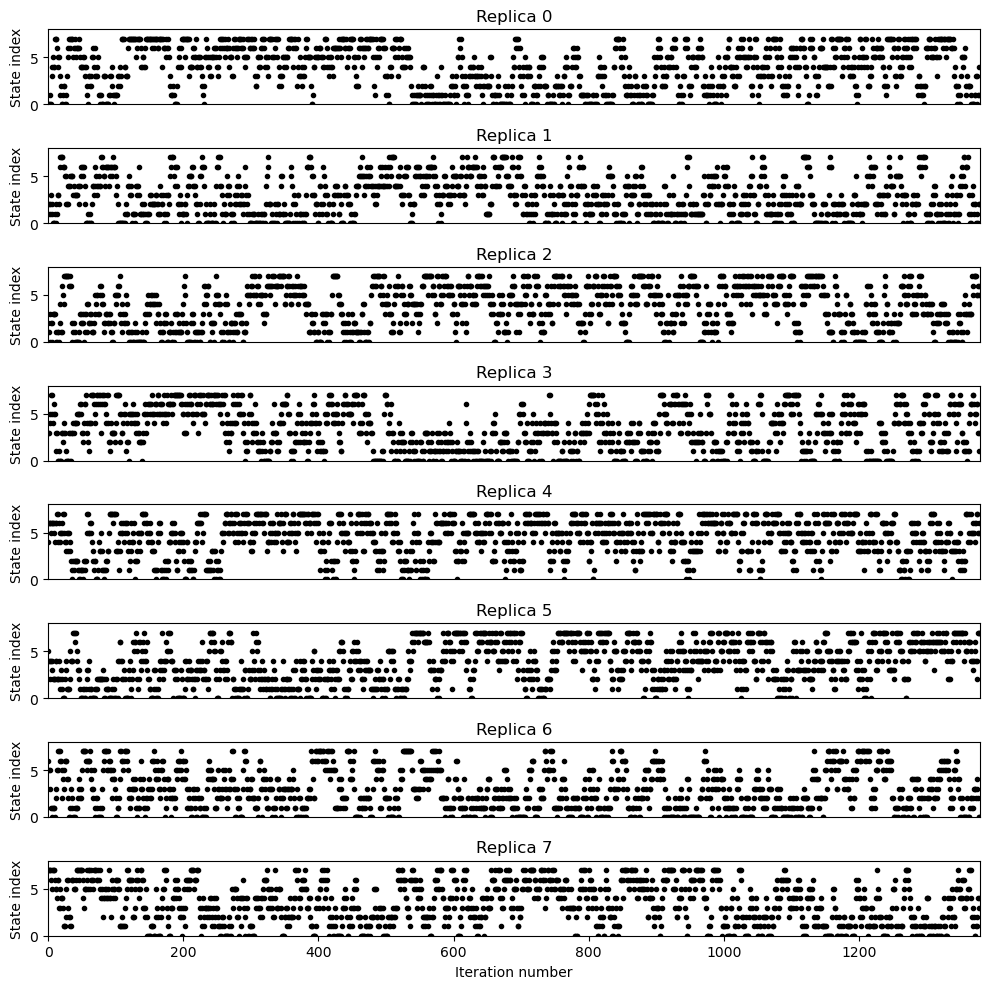

In [11]:
plot_replica_mixing(ana_sol)

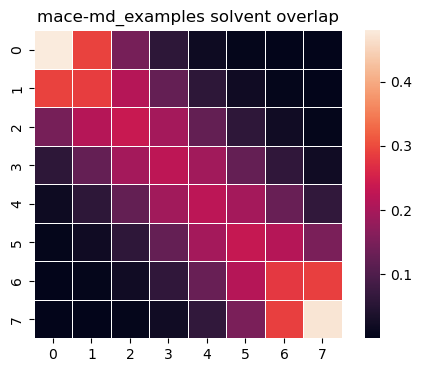

In [12]:
plot_overlap(lig=sys_name, leg="solvent", analyser=ana_sol, out_file="sim_data/solvent_repex/overlap.png")

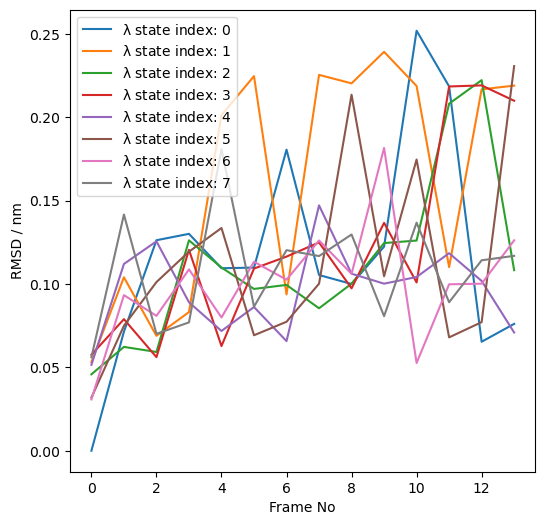

In [14]:
plot_rmsd("sim_data/solvent_repex/prepared_system.pdb", path_nc=output_sol, analyser=ana_sol, out_file="sim_data/solvent_repex/rmsd.png", resname=".pd")